In [89]:
import os
import numpy as np
import pandas as pd
import heapq
import matplotlib.pyplot as plt

In [2]:
def parse_summary(text):
    text = text[text.find('Summary'):].strip()
    text_list = text.split(';')
    for entry in text_list:
        if len(entry.strip()) < 1:
            continue
        entry_list = entry.split()
        if 'total_expanded' in entry:
            total_expanded = int(entry_list[-1])
        elif 'goal_cost' in entry:
            goal_cost = float(entry_list[-1])
        elif 'time_taken' in entry:
            time_taken = float(entry_list[-2])
    
    return [total_expanded, goal_cost, time_taken]

In [3]:
def extract_data(data_folder, isBTSNonUnit):
    sorted_files = sorted(os.listdir(data_folder), key=lambda x: int(x[x.find('_')+1: x.find('.txt')]))
    
    if (isBTSNonUnit):
        output = [[], []]
    else:
        output = []
        
    for file_name in sorted_files:
        file_data = open(os.path.join(data_folder, file_name), 'r').read()
        if (isBTSNonUnit):
            separator_index = file_data.find('--------------')
            extracted_data0 = parse_summary(file_data[:separator_index])
            extracted_data1 = parse_summary(file_data[separator_index:])
            output[0].append(extracted_data0)
            output[1].append(extracted_data1)
        else:
            extracted_data = parse_summary(file_data)
            output.append(extracted_data)
    
    return output

In [4]:
def extract_optimal_costs(file_path):
    file_lines = open(file_path, 'r').readlines()
    unit_costs = []
    nonunit_costs = []
    i = 0
    for line in file_lines:
        if "IDA*:" in line:
            for entry in line.strip().split(';'):
                entry_list = entry.strip().split()
                if 'elapsed' in entry:
                    time_taken = float(entry_list[1][:-1])
                elif 'expanded' in entry:
                    total_expanded = int(entry_list[0])
                elif 'length' in entry:
                    goal_cost = float(entry_list[-1])
                    
            unit_costs.append([total_expanded, goal_cost, time_taken])
        
        elif "IBEX:" in line:
            i+=1
            if i % 2 == 0:
                continue
            for entry in line.strip().split(';'):
                entry_list = entry.strip().split()
                if 'elapsed' in entry:
                    time_taken = float(entry_list[1][:-1])
                elif 'expanded' in entry:
                    total_expanded = int(entry_list[0])
                elif 'length' in entry:
                    goal_cost = float(entry_list[-1])
                    
            nonunit_costs.append([total_expanded, goal_cost, time_taken])
                        
    return unit_costs, nonunit_costs

# Load data from run transcripts

In [101]:
IDA_PATH = "output/IDAstar_unit"
IDANonUnit_PATH = "output/IDAstar_nonunit"
BTSUnit_PATH = "output/BTS_unit"
BTSNonUnit_PATH = "output/BTS_nonunit"

In [6]:
IDAstar_data = extract_data(IDA_PATH, False)

In [102]:
IDAstarNonUnit_data = extract_data(IDANonUnit_PATH, False)

In [7]:
BTSUnit_data = extract_data(BTSUnit_PATH, False)

In [8]:
BTSNonUnit_data, BTSNonUnitConstWin_data = extract_data(BTSNonUnit_PATH, True)

In [132]:
unit_optimal_data, non_unit_optimal_data = extract_optimal_costs('optimal_solutions.txt')

Sanity check:

In [105]:
assert len(IDAstar_data) == len(BTSUnit_data) == len(BTSNonUnit_data) == len(BTSNonUnitConstWin_data) \
== len(IDAstarNonUnit_data)*10 == len(unit_optimal_data) == len(non_unit_optimal_data) == 100

# IDA* and BTS with unit costs

## Correctness

In [11]:
for i in range(100):
    assert IDAstar_data[i][1] == BTSUnit_data[i][1] == unit_optimal_data[i][1]

## Efficiency

In [57]:
IDAstar_df = pd.DataFrame(IDAstar_data, columns=['Expanded', 'GoalCost', 'Time'])
BTSUnit_df = pd.DataFrame(BTSUnit_data, columns=['Expanded', 'GoalCost', 'Time'])
OptimalUnit_df = pd.DataFrame(unit_optimal_data, columns=['Expanded', 'GoalCost', 'Time'])

In [58]:
IDAstar_df.describe()

,Expanded,GoalCost,Time
count,1.000000e+02,100.000000,100.000000
mean,3.463564e+07,53.050000,156.437940
std,8.267563e+07,5.487129,382.022809
min,1.049400e+04,41.000000,0.091381
25%,7.699860e+05,49.750000,4.054015
50%,5.167986e+06,53.000000,23.015563
75%,2.200426e+07,57.000000,93.316974
max,5.398321e+08,66.000000,2589.104371


In [59]:
BTSUnit_df.describe()

,Expanded,GoalCost,Time
count,1.000000e+02,100.000000,100.000000
mean,3.463564e+07,53.050000,157.490404
std,8.267563e+07,5.487129,388.830030
min,1.049400e+04,41.000000,0.091414
25%,7.699860e+05,49.750000,3.953372
50%,5.167986e+06,53.000000,23.010662
75%,2.200426e+07,57.000000,93.130756
max,5.398321e+08,66.000000,2698.269314


In [60]:
OptimalUnit_df.describe()

,Expanded,GoalCost,Time
count,1.000000e+02,100.000000,100.000000
mean,2.424608e+08,53.050000,31.968900
std,9.587023e+08,5.487129,133.693459
min,7.442400e+04,41.000000,0.010000
25%,4.344587e+06,49.750000,0.460000
50%,2.581199e+07,53.000000,2.805000
75%,1.217943e+08,57.000000,13.212500
max,8.856207e+09,66.000000,1250.520000


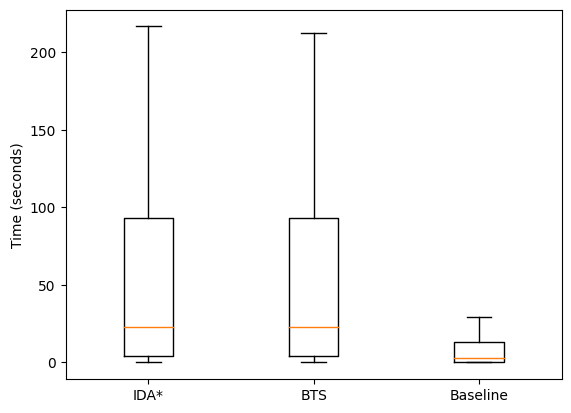

In [62]:
plt.boxplot([IDAstar_df['Time'], BTSUnit_df['Time'], OptimalUnit_df['Time']], showfliers=False)
plt.ylabel('Time (seconds)')
plt.xticks([1,2,3], ['IDA*', 'BTS', 'Baseline'])
plt.show()

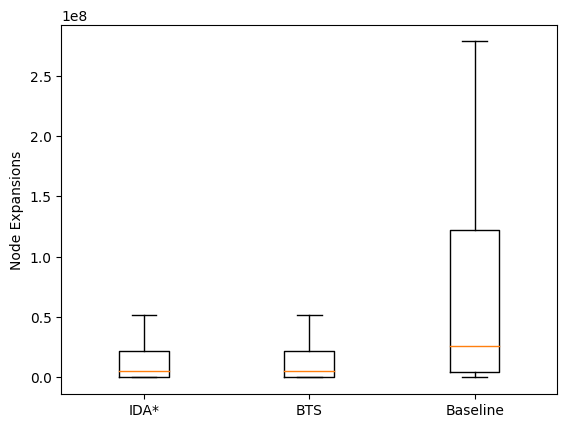

In [66]:
plt.boxplot([IDAstar_df['Expanded'], BTSUnit_df['Expanded'], OptimalUnit_df['Expanded']], showfliers=False)
plt.ylabel('Node Expansions')
plt.xticks([1,2, 3], ['IDA*', 'BTS', 'Baseline'])
plt.show()

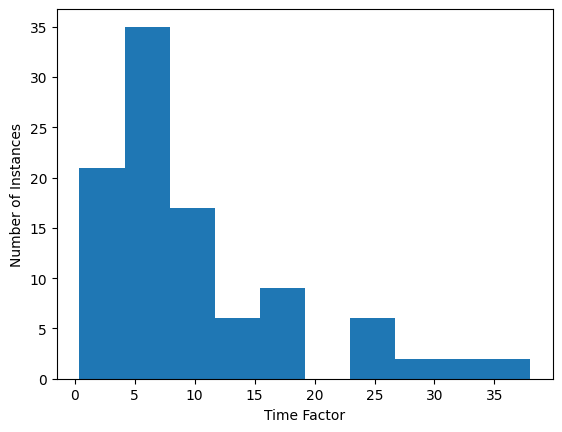

In [67]:
out = IDAstar_df['Time'] / OptimalUnit_df['Time']
plt.hist(out)
plt.ylabel('Number of Instances')
plt.xlabel('Time Factor')
plt.show()

# BTS with non-unit costs

## Correctness

In [34]:
for i in range(100):
    assert BTSNonUnit_data[i][1] == BTSNonUnitConstWin_data[i][1] == non_unit_optimal_data[i][1]

## Efficiency

In [40]:
BTSNonUnit_df = pd.DataFrame(BTSNonUnit_data, columns=['Expanded', 'GoalCost', 'Time'])
BTSNonUnitConstWin_df = pd.DataFrame(BTSNonUnitConstWin_data, columns=['Expanded', 'GoalCost', 'Time'])
OptimalNonUnit_df = pd.DataFrame(non_unit_optimal_data, columns=['Expanded', 'GoalCost', 'Time'])

In [37]:
BTSNonUnit_df.describe()

,Expanded,GoalCost,Time
count,1.000000e+02,100.000000,100.000000
mean,5.951453e+08,61.334357,546.997869
std,1.668935e+09,6.223567,1609.659521
min,5.170890e+05,47.814719,0.423890
25%,1.362530e+07,57.485186,10.947756
50%,6.075907e+07,61.619157,48.000806
75%,3.639104e+08,65.703180,269.550837
max,1.394143e+10,76.014932,10878.866681


In [38]:
BTSNonUnitConstWin_df.describe()

,Expanded,GoalCost,Time
count,1.000000e+02,100.000000,100.000000
mean,1.194576e+09,61.334357,1092.887658
std,2.493155e+09,6.223567,2712.861046
min,1.288471e+06,47.814719,1.061934
25%,4.453436e+07,57.485186,35.249891
50%,1.749074e+08,61.619157,135.251076
75%,9.502479e+08,65.703180,751.327729
max,1.417489e+10,76.014932,17164.313165


In [41]:
OptimalNonUnit_df.describe()

,Expanded,GoalCost,Time
count,1.000000e+02,100.000000,100.000000
mean,6.730514e+08,61.334357,100.093500
std,2.237464e+09,6.223567,287.717804
min,5.380560e+05,47.814719,0.070000
25%,1.483695e+07,57.485186,1.787500
50%,6.611217e+07,61.619157,8.055000
75%,3.390898e+08,65.703180,45.277500
max,1.835286e+10,76.014932,2266.890000


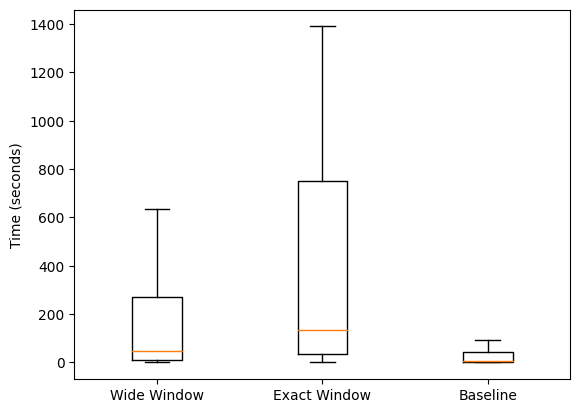

In [73]:
plt.boxplot([BTSNonUnit_df['Time'], BTSNonUnitConstWin_df['Time'], OptimalNonUnit_df['Time']], showfliers=False)
plt.ylabel('Time (seconds)')
plt.xticks([1,2,3], ['Wide Window', 'Exact Window', 'Baseline'])
plt.show()

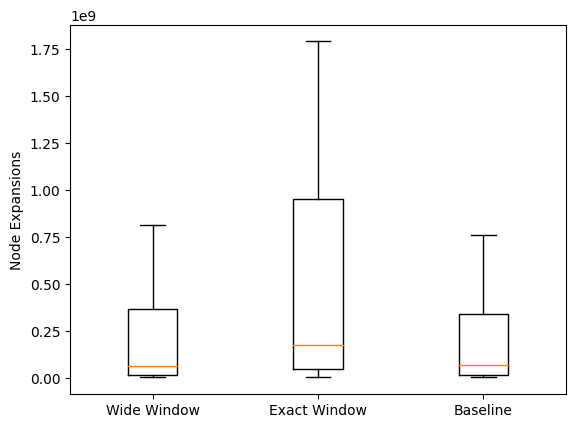

In [98]:
plt.boxplot([BTSNonUnit_df['Expanded'], BTSNonUnitConstWin_df['Expanded'], OptimalNonUnit_df['Expanded']], showfliers=False)
plt.ylabel('Node Expansions')
plt.xticks([1,2,3], ['Wide Window', 'Exact Window', 'Baseline'])
plt.show()

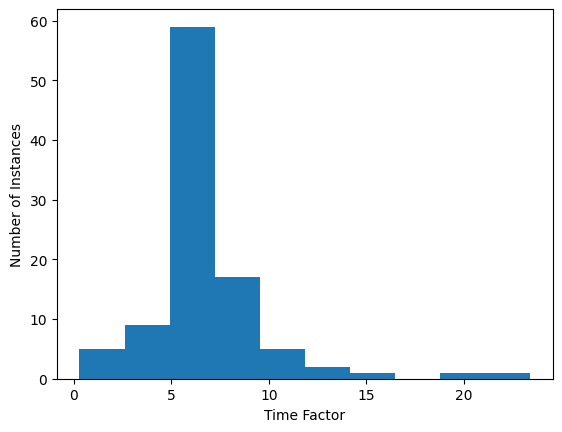

In [70]:
out = BTSNonUnit_df['Time'] / OptimalNonUnit_df['Time']
plt.hist(out)
plt.ylabel('Number of Instances')
plt.xlabel('Time Factor')
plt.show()

# IDA* with non-unit costs

In [133]:
smallest = heapq.nsmallest(10, BTSNonUnit_data,  key=lambda x: x[2])
smallest_indices = sorted([BTSNonUnit_data.index(x) for x in smallest])
BTS_smallest_data = [BTSNonUnit_data[i] for i in smallest_indices]
Optimal_smallest_data = [non_unit_optimal_data[i] for i in smallest_indices]
BTS_smallest_df = pd.DataFrame(BTS_smallest_data, columns=['Expanded', 'GoalCost', 'Time']) 
Optimal_smallest_df = pd.DataFrame(Optimal_smallest_data, columns=['Expanded', 'GoalCost', 'Time']) 
IDAstarNonUnit_df = pd.DataFrame(IDAstarNonUnit_data, columns=['Expanded', 'GoalCost', 'Time']) 

In [134]:
BTS_smallest_df

,Expanded,GoalCost,Time
0,1416890,52.315340,1.154662
1,1470916,53.024290,1.304507
2,2014644,58.000683,1.603173
3,613162,49.513122,0.491572
4,1935476,58.165462,1.547022
5,517089,47.814719,0.423890
6,2204603,57.494787,1.742596
7,551958,48.464344,0.461091
8,1632178,50.697269,1.256688
9,1014396,62.059348,0.778367


In [135]:
IDAstarNonUnit_df

,Expanded,GoalCost,Time
0,114632606,52.315340,91.679124
1,294985941,53.024290,243.194770
2,565177688,58.000683,458.057134
3,276775765,49.513122,219.584285
4,453805521,58.165462,360.908887
5,191288672,47.814719,156.292170
6,672283735,57.494787,531.248395
7,209677924,48.464344,165.952296
8,275265554,50.697269,218.729915
9,74825738,62.059348,59.804999


In [136]:
Optimal_smallest_df

,Expanded,GoalCost,Time
0,874216,52.315340,0.11
1,2001761,53.024290,0.25
2,2167922,58.000683,0.26
3,602068,49.513122,0.07
4,1809509,58.165462,0.22
5,538056,47.814719,0.07
6,2578661,57.494787,0.32
7,558348,48.464344,0.07
8,1857438,50.697269,0.23
9,1915839,62.059348,0.23


## Correctness

In [137]:
for i in range(10):
    assert IDAstarNonUnit_data[i][1] == BTS_smallest_data[i][1] == Optimal_smallest_data[i][1]

## Efficiency

In [124]:
IDAstarNonUnit_df.describe()

,Expanded,GoalCost,Time
count,1.000000e+01,10.000000,10.000000
mean,3.128719e+08,53.754936,250.545198
std,1.935432e+08,4.872303,154.099642
min,7.482574e+07,47.814719,59.804999
25%,1.958860e+08,49.809159,158.707201
50%,2.760207e+08,52.669815,219.157100
75%,4.141006e+08,57.874209,331.480358
max,6.722837e+08,62.059348,531.248395


In [125]:
BTS_smallest_df.describe()

,Expanded,GoalCost,Time
count,1.000000e+01,10.000000,10.000000
mean,1.337131e+06,53.754936,1.076357
std,6.322900e+05,4.872303,0.502071
min,5.170890e+05,47.814719,0.423890
25%,7.134705e+05,49.809159,0.563271
50%,1.443903e+06,52.669815,1.205675
75%,1.859652e+06,57.874209,1.486393
max,2.204603e+06,62.059348,1.742596


In [138]:
Optimal_smallest_df.describe()

,Expanded,GoalCost,Time
count,1.000000e+01,10.000000,10.000000
mean,1.490382e+06,53.754936,0.183000
std,7.649895e+05,4.872303,0.093458
min,5.380560e+05,47.814719,0.070000
25%,6.701050e+05,49.809159,0.080000
50%,1.833474e+06,52.669815,0.225000
75%,1.980280e+06,57.874209,0.245000
max,2.578661e+06,62.059348,0.320000


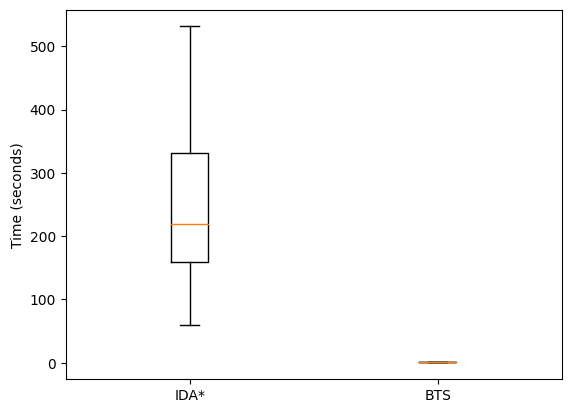

In [120]:
plt.boxplot([IDAstarNonUnit_df['Time'], BTS_smallest_df['Time']], showfliers=False)
plt.ylabel('Time (seconds)')
plt.xticks([1,2], ['IDA*', 'BTS'])
plt.show()

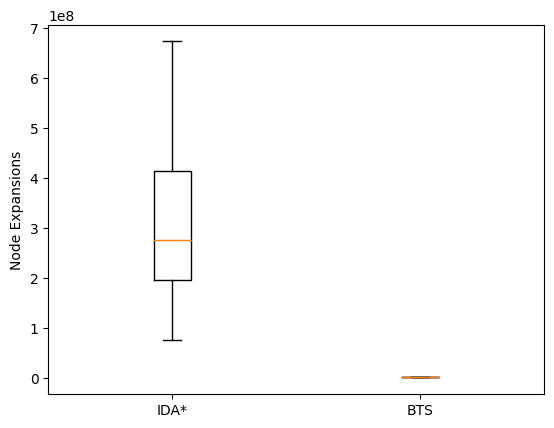

In [122]:
plt.boxplot([IDAstarNonUnit_df['Expanded'], BTS_smallest_df['Expanded']], showfliers=False)
plt.ylabel('Node Expansions')
plt.xticks([1,2], ['IDA*', 'BTS'])
plt.show()

In [126]:
out = IDAstarNonUnit_df['Time']/ BTS_smallest_df['Time']
out.mean()

251.59039993689066

In [127]:
out = IDAstarNonUnit_df['Expanded']/ BTS_smallest_df['Expanded']
out.mean()

254.50154676812176